# Effects of data smoothing on parameter estimates



In [1]:
import jax.numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

import seaborn as sns

from jax import random, nn
from jax.experimental.ode import odeint

import numpyro as npyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import substitute, condition

from numpyro.distributions.transforms import AffineTransform, ExpTransform, ComposeTransform, IdentityTransform
from IPython.display import clear_output

npyro.enable_validation(True)
npyro.set_host_device_count(2)
plt.style.use('seaborn-notebook')
%config InlineBackend.figure_format = 'retina'

In [57]:
def fun_g(X, I, aX, aI, g0):
    
    return g0/(1 + aX * X + aI * I)

def fun_I(x, aX, aI, g0):
    par1 = (g0 + aX)/(g0 - aI)
    par2 = (1 + aX)/aI
    
    return par1 * x + (par1 + par2) * (np.exp(np.log(1 - x) * aI/g0) - 1)

def model(N, data, obs=None):
    """
    :param int T: number of measured data points
    :param numpy.ndarray N: total population size for different categories with shape (K,)
    :param pandas.DataFrame data: collected data for X, I, D
    :param numpy.ndarray obs: 
    :param int K: number of categories
    """
    
    # infer the fraction of the total population that can be infected. With this we also assume a possible 
    # presence of social, biological or geographical barriers to the disease spreading.
    f = npyro.sample('f', dist.Exponential(np.ones(1)))
    normalisation_factor = npyro.deterministic('nf', f * float(N))
    
    X_data = data['X']
    I_data = data['I']
    dF_data = data['dF']
    
    a_X = npyro.sample('a_X', dist.Gamma(20., 2.))
    a_I = npyro.sample('a_I', dist.Gamma(1000., 2.))
    
    g0 = npyro.sample('g0', dist.Gamma(3., 2.))
    
    X_n = X_data/normalisation_factor
    I_n = fun_I(X_n, a_X, a_I, g0)
        
    I = npyro.deterministic('I', normalisation_factor * np.where(I_n > 0, I_n, 0.))
    
    tau = npyro.sample('tau', dist.Gamma(2., 2.))
    g = npyro.deterministic('g', fun_g(X_n, I_n, a_X, a_I, g0))
    
    c = npyro.deterministic('c', (dF_data * data['mask_2']).sum() / X_data[-1])
    dF = npyro.deterministic('dF', c * normalisation_factor * I_n)
        
    # measurement errors
    scale = npyro.sample("scale", dist.InverseGamma(2., np.ones(2)))
    
    x_t = npyro.deterministic('x_t', (g * (1-X_n) - 1)/tau)
    with npyro.plate('data', X_data.shape[0] - 2):
        dist1 = dist.Normal(x_t[:-2], np.sqrt(scale[0]))
        npyro.sample("obs", dist.MaskedDistribution(dist1, mask=data['mask_1']), obs=obs)
    
    with npyro.plate('data_2', X_data.shape[0] - 1):
        dist2 = dist.StudentT(5., dF[:-1], np.sqrt(scale[1]))
        npyro.sample("obs2", dist.MaskedDistribution(dist2, mask=data['mask_2']), obs=dF_data)

In [3]:
# load information about the population in different regions
df_N = pd.read_csv('region_population.csv', index_col=0)

#########################                  
# Note that the region of Trentino-Alto Adige covers, regions of P.A. Bolzano and P.A. Trento which
# are included in the italy's. Hence we will combine them in one in the table bellow. 
#########################

# Load national data in Italy
df_national = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

# Load and format region specific data.
df_regional = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-regioni/dpc-covid19-ita-regioni.csv')

df_regional = df_regional.set_index('data')

# Merge data for Trento and Bolzano into Trentino-Alto Adige
loc_bolz = df_regional.denominazione_regione == 'P.A. Bolzano'
loc_tren = df_regional.denominazione_regione == 'P.A. Trento'

df_ta = df_regional.loc[loc_bolz, 'totale_positivi':] + \
        df_regional.loc[loc_tren, 'totale_positivi':]

df_ta['denominazione_regione'] = 'Trentino-Alto Adige'

df_regional = df_regional.append(df_ta).reset_index()
df_regional = df_regional.drop(df_regional[df_regional.denominazione_regione == 'P.A. Bolzano'].index)
df_regional = df_regional.drop(df_regional[df_regional.denominazione_regione == 'P.A. Trento'].index)

In [4]:
df_national.rename(columns={'data': 'date', 
                            'casi_testati': 'total tests',
                            'totale_casi':'X',
                            'nuovi_positivi': 'I',
                            'deceduti': 'D'}, 
                      inplace=True)

df_national['dD'] = df_national['D'].diff()
df_national.loc[0, 'dD'] = df_national.loc[0, 'D']

df_regional.rename(columns={'data': 'date', 
                            'casi_testati': 'total tests', 
                            'denominazione_regione': 'region',
                            'totale_casi':'X',
                            'nuovi_positivi': 'I',
                            'deceduti': 'D'}, 
                     inplace=True)


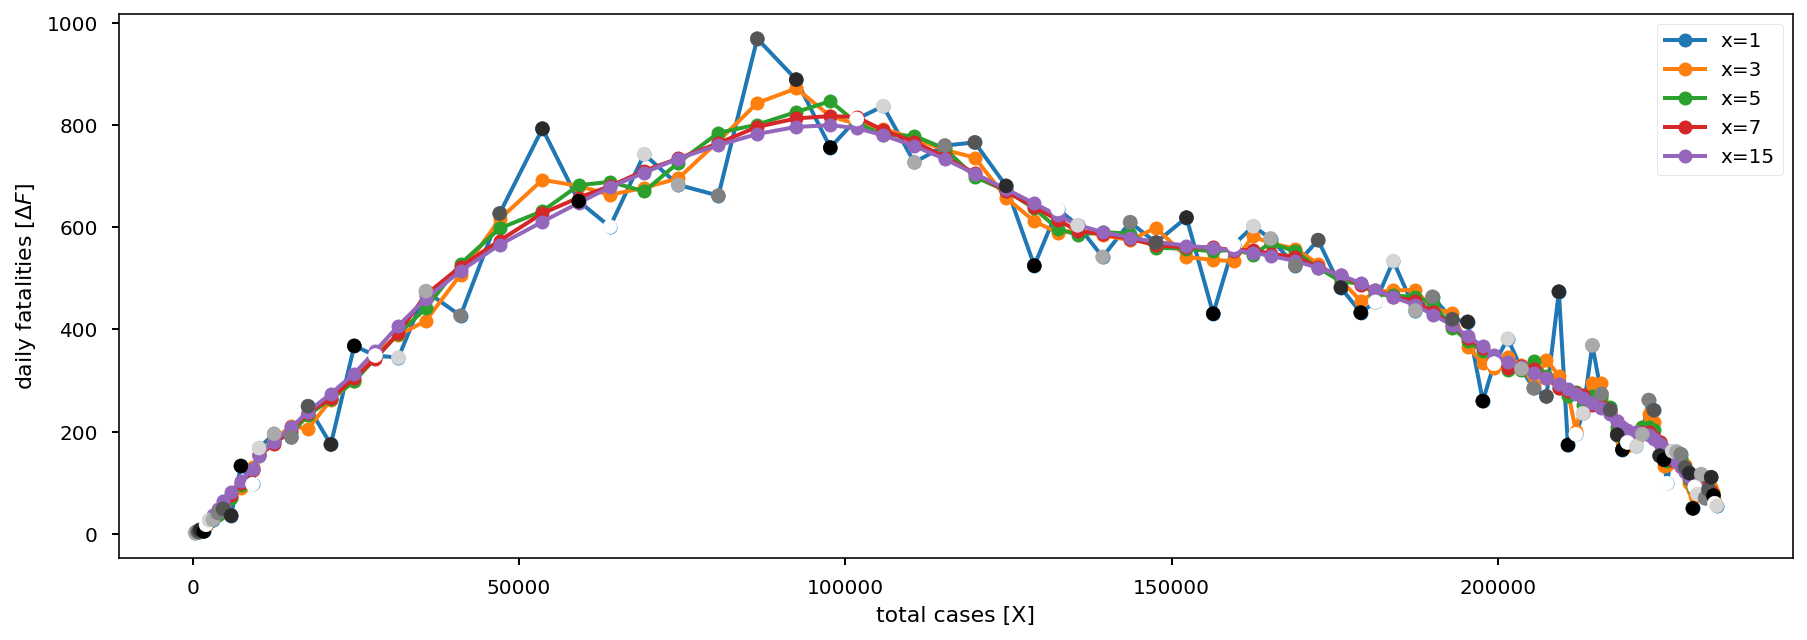

In [5]:
# plot data smoothed with x-days moving average

days = pd.to_datetime(df_national.date, infer_datetime_format=True).dt.dayofweek

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for x in [1, 3, 5, 7, 15]:
    dF = df_national.D.diff().rolling(window=x, center=True, win_type='gaussian').mean(std=2.6)
    X = df_national.X.rolling(window=1, center=True, win_type='gaussian').mean(std=2.6)
    axes.plot(X, dF, 'o-', label='x={}'.format(x), lw=2)

axes.scatter(df_national.X.values, df_national.D.diff().values, c=days.values/6., cmap='gray_r', zorder=10)

axes.set_ylabel(r'daily fatalities [$\Delta F$]');
axes.set_xlabel('total cases [X]');
axes.legend();

fig.savefig('smoothing.png', dpi=300)

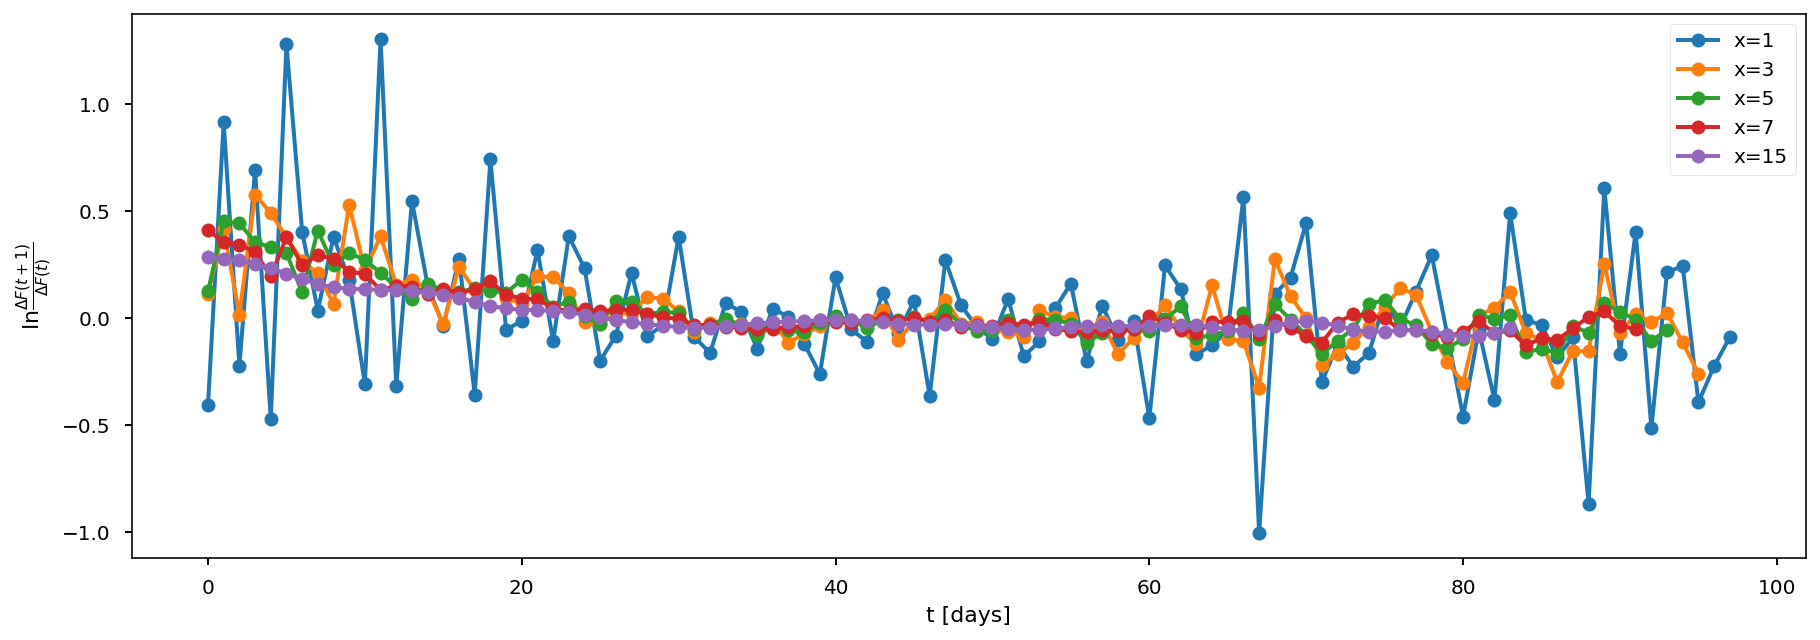

In [6]:
import numpy as onp
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for x in [1, 3, 5, 7, 15]:
    dF = df_national.D.diff().rolling(window=x, center=True, win_type='gaussian').mean(std=2.6).dropna()
    
    log_ratios = onp.log(dF.values[1:]) - onp.log(dF.values[:-1])
    
    axes.plot(log_ratios, 'o-', label='x={}'.format(x), lw=2)

axes.set_ylabel(r'$\ln \frac{\Delta F(t+1)}{\Delta F(t)}$');
axes.set_xlabel('t [days]');
axes.legend();

In [60]:
# fitting the static model
num_warmup = 1000
num_samples = 1000

N = df_N.Population.sum()
samples2 = {}
rng_key = random.PRNGKey(24412457)
for x in [3, 5, 7, 15]:
    dF = df_national.D.diff().rolling(window=x, center=True, win_type='gaussian').mean(std=2.6).iloc[1:-(x-1)//2]
    I = df_national.I.rolling(window=x, center=True, win_type='gaussian').mean(std=2.6).iloc[:-(x-1)//2]
    X = df_national.X.rolling(window=x, center=True, win_type='gaussian').mean(std=2.6).iloc[:-(x-1)//2]
    
    mask_2 = ~np.isnan(dF.values)
    
    obs = onp.log(dF).diff().values[1:]
    mask_1 = ~np.isnan(obs)
    obs = np.nan_to_num(obs)
    
    data = {'mask_1': mask_1,
            'mask_2': mask_2,
            'X': np.array(X.fillna(0.).values),
            'I': np.array(I.where(I > 1., 1.).values),
            'dF': np.array(dF.where(dF > 1., 1.).values)}
    
    nuts = NUTS(condition(model, {}), max_tree_depth=12, target_accept_prob=.9)
    mcmc = MCMC(nuts, num_warmup, num_samples)
    mcmc.run(rng_key, N=N, data=data, obs=obs)
    mcmc.print_summary()
    samples2[x] = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:14<00:00, 138.43it/s, 127 steps of size 2.54e-02. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I    483.49     15.45    483.36    457.34    507.81    742.07      1.00
       a_X     25.91      1.72     25.89     22.91     28.42    357.34      1.00
      f[0]      0.49      0.04      0.49      0.44      0.55    344.74      1.00
        g0      1.17      0.01      1.17      1.16      1.18    436.77      1.00
  scale[0]      0.04      0.01      0.03      0.03      0.04    907.46      1.00
  scale[1]   1282.11    247.89   1246.09    913.43   1664.93    570.64      1.00
       tau      0.68      0.12      0.66      0.50      0.86    745.88      1.00

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:14<00:00, 139.44it/s, 255 steps of size 2.53e-02. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I    483.24     15.12    483.15    457.88    507.82    610.18      1.00
       a_X     26.37      1.56     26.33     23.78     28.83    372.63      1.00
      f[0]      0.50      0.03      0.50      0.45      0.55    349.47      1.00
        g0      1.17      0.01      1.17      1.16      1.17    473.09      1.00
  scale[0]      0.03      0.00      0.03      0.02      0.03    856.72      1.00
  scale[1]    880.96    165.79    860.32    629.12   1146.38    681.28      1.00
       tau      0.67      0.10      0.65      0.51      0.82    663.75      1.00

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:15<00:00, 130.68it/s, 191 steps of size 2.23e-02. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I    482.00     14.89    481.00    457.99    506.82    589.13      1.00
       a_X     26.92      1.52     26.86     24.34     29.27    373.31      1.00
      f[0]      0.51      0.03      0.51      0.47      0.56    351.47      1.00
        g0      1.16      0.00      1.16      1.16      1.17    428.42      1.00
  scale[0]      0.02      0.00      0.02      0.02      0.03    758.46      1.00
  scale[1]    655.56    131.55    637.89    468.30    865.86    661.79      1.00
       tau      0.67      0.10      0.66      0.51      0.82    621.22      1.00

Number of divergences: 0


sample: 100%|██████████| 2000/2000 [00:16<00:00, 124.62it/s, 191 steps of size 2.25e-02. acc. prob=0.96] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I    482.28     14.98    481.86    456.35    505.70    500.45      1.00
       a_X     26.97      1.54     26.96     24.53     29.61    287.23      1.00
      f[0]      0.52      0.03      0.52      0.48      0.58    283.89      1.00
        g0      1.16      0.00      1.16      1.15      1.17    385.51      1.00
  scale[0]      0.02      0.00      0.02      0.02      0.03    778.10      1.00
  scale[1]    547.18    114.18    529.81    362.97    694.39    576.57      1.00
       tau      0.78      0.16      0.76      0.53      0.99    698.65      1.00

Number of divergences: 0


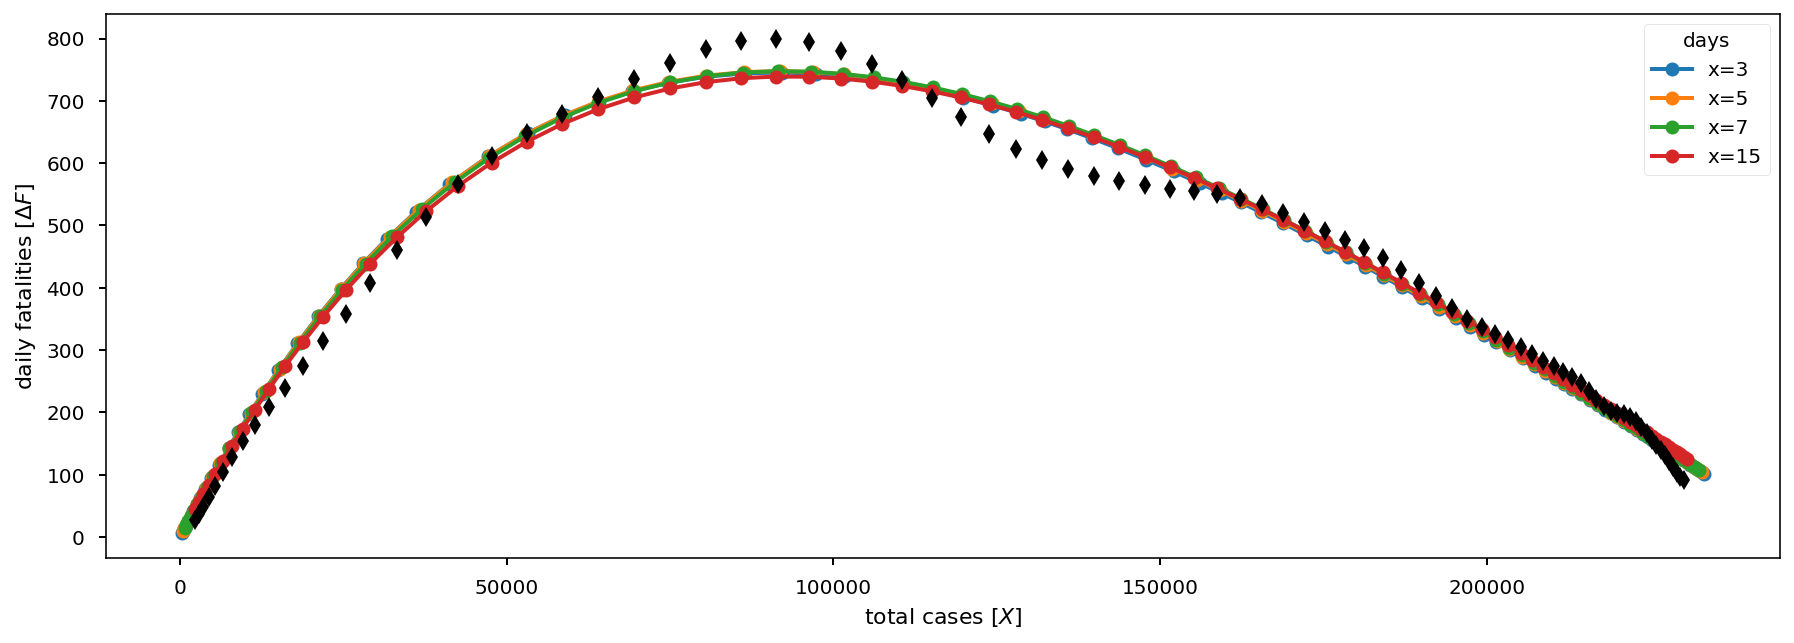

In [62]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for x in samples2:
    X = df_national.X.rolling(window=x, center=True, win_type='gaussian').mean(std=2.6).iloc[:-(x-1)//2].values
    dF = df_national.D.diff().rolling(window=x, center=True, win_type='gaussian').mean(std=2.6).iloc[1:-(x-1)//2]
    dX = df_national.X.diff().rolling(window=x, center=True, win_type='gaussian').mean(std=2.6).iloc[1:-(x-1)//2]
        
    axes.plot(X, np.mean(samples2[x]['dF'], 0), 'o-', label='x={}'.format(x), lw=2)
    if x == 15:
        axes.plot(X[:-1], dF, 'kd')

axes.set_ylabel(r'daily fatalities [$\Delta F$]');
axes.set_xlabel(r'total cases [$X$]');
axes.legend(title='days');

In [65]:
a_x

NameError: name 'a_x' is not defined

/run/media/dimitrije/data/anaconda/envs/jax/lib/python3.8/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/run/media/dimitrije/data/anaconda/envs/jax/lib/python3.8/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


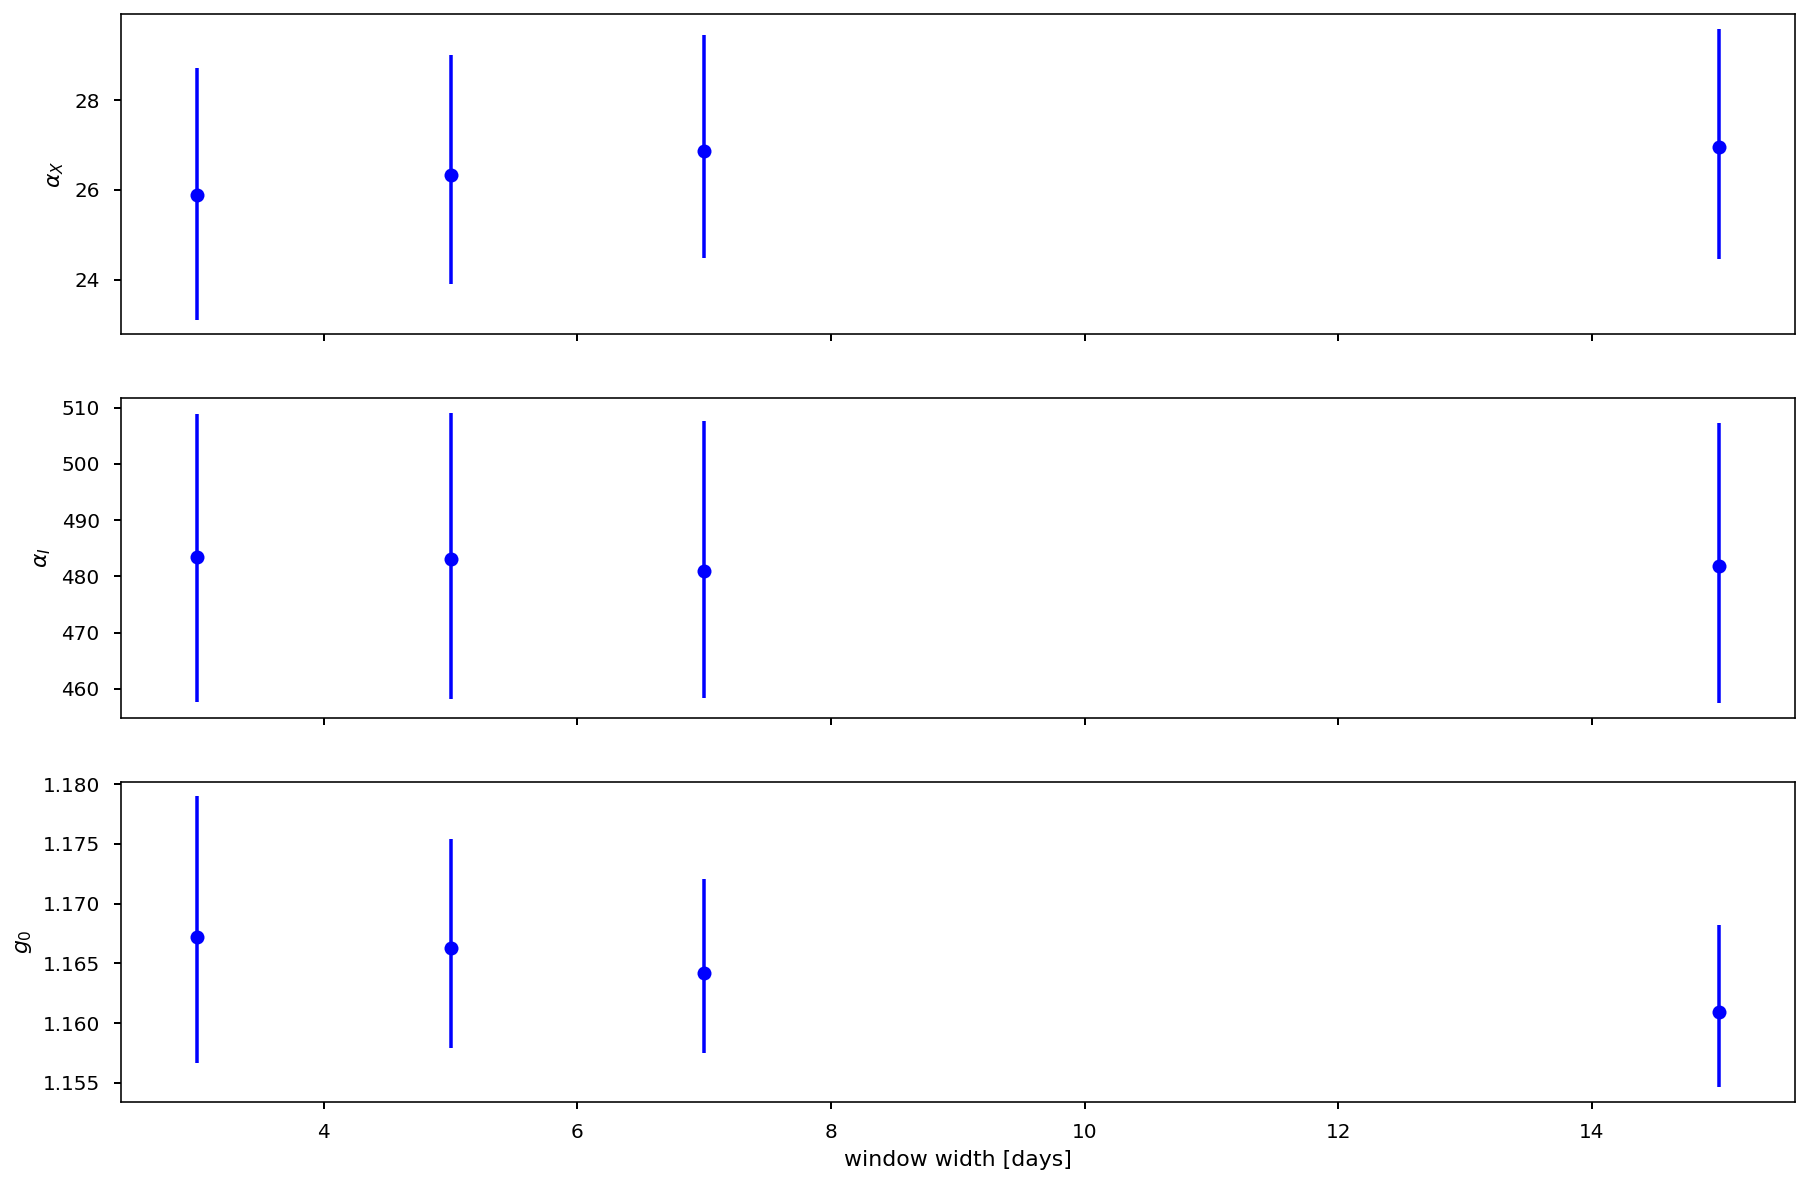

In [66]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for x in samples2:
    a_x = np.percentile(samples2[x]['a_X'], [5, 50, 95])
    yerr = np.array([a_x[1] - a_x[0], a_x[-1] - a_x[1]])[:, None]
    axes[0].errorbar(x, a_x[1], yerr=yerr, marker='o', color='b')
    axes[0].set_ylabel(r'$\alpha_X$')
    
    a_i = np.percentile(samples2[x]['a_I'], [5, 50, 95])
    yerr = np.array([a_i[1] - a_i[0], a_i[-1] - a_i[1]])[:, None]
    axes[1].errorbar(x, a_i[1], yerr=yerr, marker='o', color='b')
    axes[1].set_ylabel(r'$\alpha_I$')
    
    g = np.percentile(samples2[x]['g0'], [5, 50, 95])
    yerr = np.array([g[1] - g[0], g[-1] - g[1]])[:, None]
    axes[2].errorbar(x, g[1], yerr=yerr, marker='o', color='b')
    axes[2].set_ylabel(r'$g_0$')
    
axes[-1].set_xlabel('window width [days]');

# Confirmation delay based smoothing

Instead of using moving averages for data smoothing we can adopt a more data driven appraoch. What we are interested in is knowing the delay between the onset of the disease and the date on which the deases is reported. this information would allow us to smooth out data variability and distribute cases reported on day $t$ to all the previous days given the possible delays between the real onset of the disease and the confirmation.

To estimate the delay distribution we will use the detailed data of worldwide covid-19 cases reported at 

https://github.com/beoutbreakprepared/nCoV2019/

The procedure described here is copied from the notebooks availible at 

https://github.com/k-sys/covid-19


In [10]:
df = pd.read_csv(
    'latestdata.tar.gz',
    usecols=[
        'date_confirmation',
        'date_onset_symptoms',
        'country_new'
    ],
    parse_dates=False,
    low_memory=False)

In [18]:
df.dropna()['country_new'].unique()

array(['China', 'Singapore', 'Japan', 'South Korea', 'Malaysia', 'Italy',
       'Finland', 'Canada', 'Pakistan', 'Germany', 'Croatia', 'Spain',
       'United States', 'Romania', 'Cambodia', 'Iceland', 'Tunisia',
       'Portugal', 'Nepal', 'Australia', 'Philippines', 'South Africa',
       'Bhutan', 'France', 'Brazil', 'Malta', 'Switzerland', 'Vietnam',
       'Thailand', 'Angola', 'Burkina Faso', 'Cabo Verde',
       'Central African Republic', "Cote d'Ivoire", 'Gabon', 'Sudan',
       'Uganda', 'Argentina', 'Guatemala', 'Mexico', 'Chile', 'Cuba'],
      dtype=object)

In [19]:
# Load the patient CSV downlaoded from https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz
patients = pd.read_csv(
    'latestdata.tar.gz',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms',
        'country_new'
    ],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed', 'Country']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

In [20]:
len(patients)

2513

In [50]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

p_country_delay = {}
for country in patients.Country.unique():
    df = patients.loc[patients.Country == country]
    if len(df) > 50:
        print(len(df), country)
        delay = (df.Confirmed - df.Onset).dt.days
    
        df_delay = delay.value_counts().sort_index()
        new_range = np.arange(0, df_delay.index.max()+1)
        df_delay = df_delay.reindex(new_range, fill_value=0)
        df_delay /= df_delay.sum()
        p_country_delay[country] = df_delay

904 China
277 Singapore
506 Japan
90 South Korea
553 Mexico


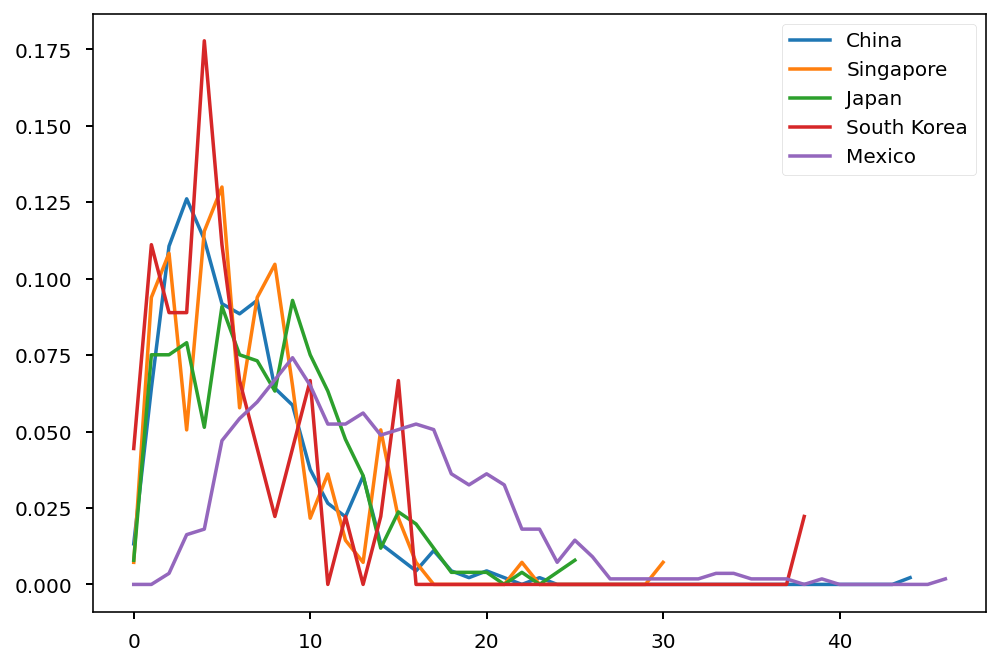

In [49]:
for country in p_country_delay:
    plt.plot(p_country_delay[country], label=country)

plt.legend()

In [7]:
from numpyro import optim
from numpyro.infer import SVI, ELBO
from jax import random, lax

def model(obs):
    
    conc = npyro.param('conc', np.ones(1))
    rate = npyro.param('rate', np.ones(1))
    
    npyro.sample('obs', dist.GammaPoisson(conc, rate), obs=obs)
    
def empty(obs):
    pass

svi = SVI(model, empty, optim.Adam(0.001), ELBO(num_particles=1000))
svi_state = svi.init(random.PRNGKey(10101), obs=delay.values)

num_iters = 10000
last_state, losses = lax.scan(lambda state, i: svi.update(state,obs=delay.values), 
                              svi_state, 
                              np.zeros(num_iters))

params = svi.get_params(last_state)

In [8]:
k = np.arange(len(p_delay))
model_delay = np.exp(dist.GammaPoisson(params['conc'], params['rate']).log_prob(k))

np.savez('delay_dist.npz', data_delay=p_delay.values, fit_delay=model_delay)

Let us illustrate the relationship between onset of symptoms and confirmation, and the corresponding delay distribution.


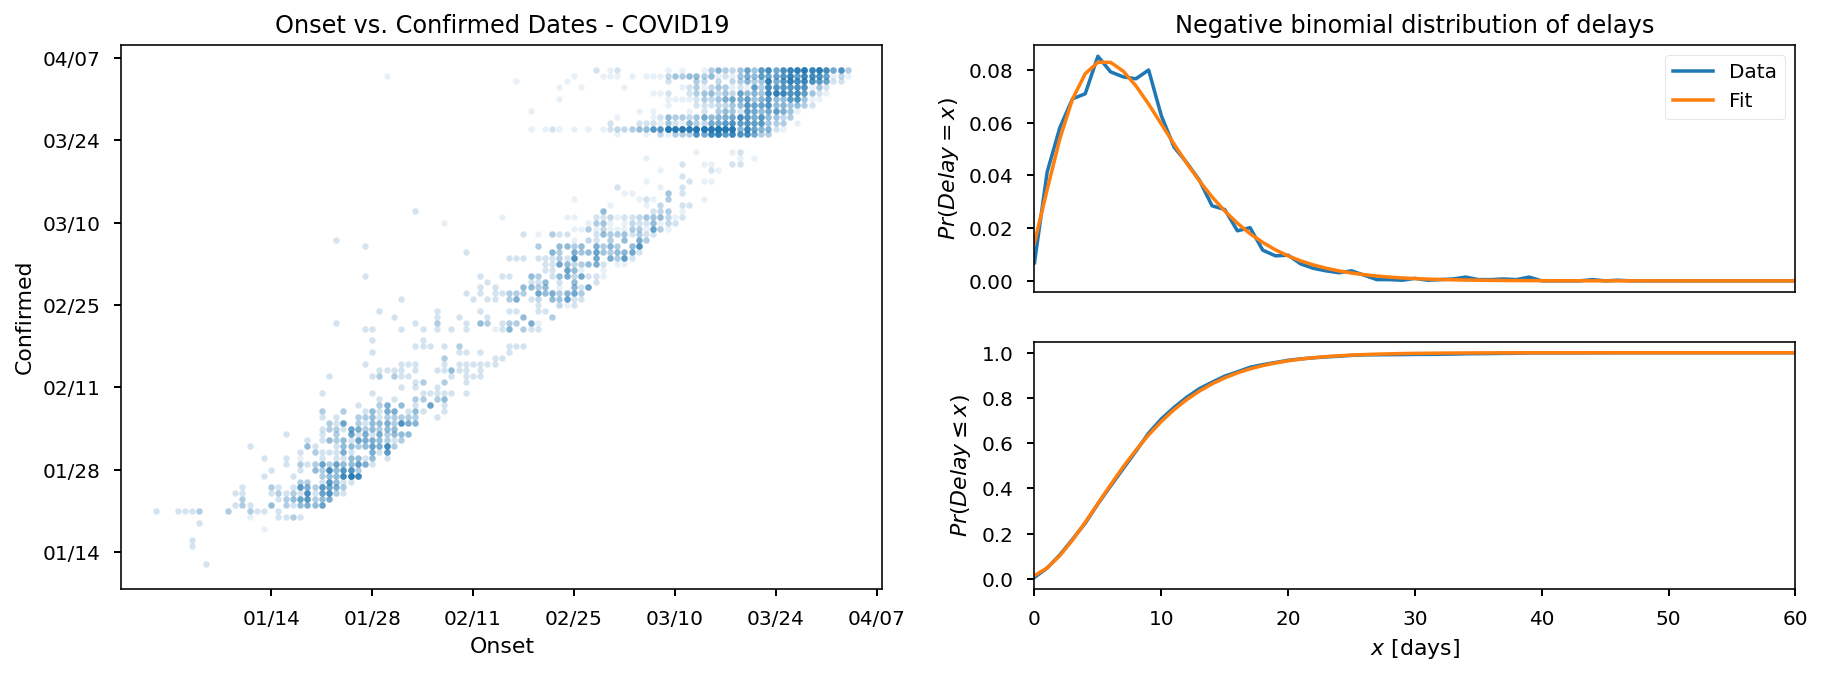

In [9]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[:, 0])
axes = [ax1]
for i in range(2):
    axes.append(fig.add_subplot(gs[i, 1]))
    
patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    ax=axes[0])

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [axes[0].xaxis, axes[0].yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)
    
axes[1].set_title('Negative binomial distribution of delays')
p_delay.plot(ax=axes[1], label='Data');
axes[1].plot(model_delay, label='Fit')
axes[1].set_ylabel(r'$Pr(Delay=x)$');
axes[1].legend()
p_delay.cumsum().plot(ax=axes[2]);
axes[2].plot(model_delay.cumsum())
axes[2].set_ylabel(r'$Pr(Delay \leq x)$');
axes[-1].set_xlabel(r'$x$ [days]');
axes[1].set_xticks([]);
axes[1].set_xlim([0, 60]);
axes[2].set_xlim([0, 60]);

fig.savefig('Delays_DM.pdf', bbox_inches='tight', transparent=True, dpi=300)

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [10]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset

df_national.date = pd.to_datetime(df_national.date, infer_datetime_format=True).dt.date

confirmed = df_national.set_index('date').I
onset = confirmed_to_onset(confirmed, model_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day (the last day in the series).

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [11]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.onp.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.onp.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, model_delay)

Lets take a look at all three series: confirmed, onset and onset adjusted for right censoring.

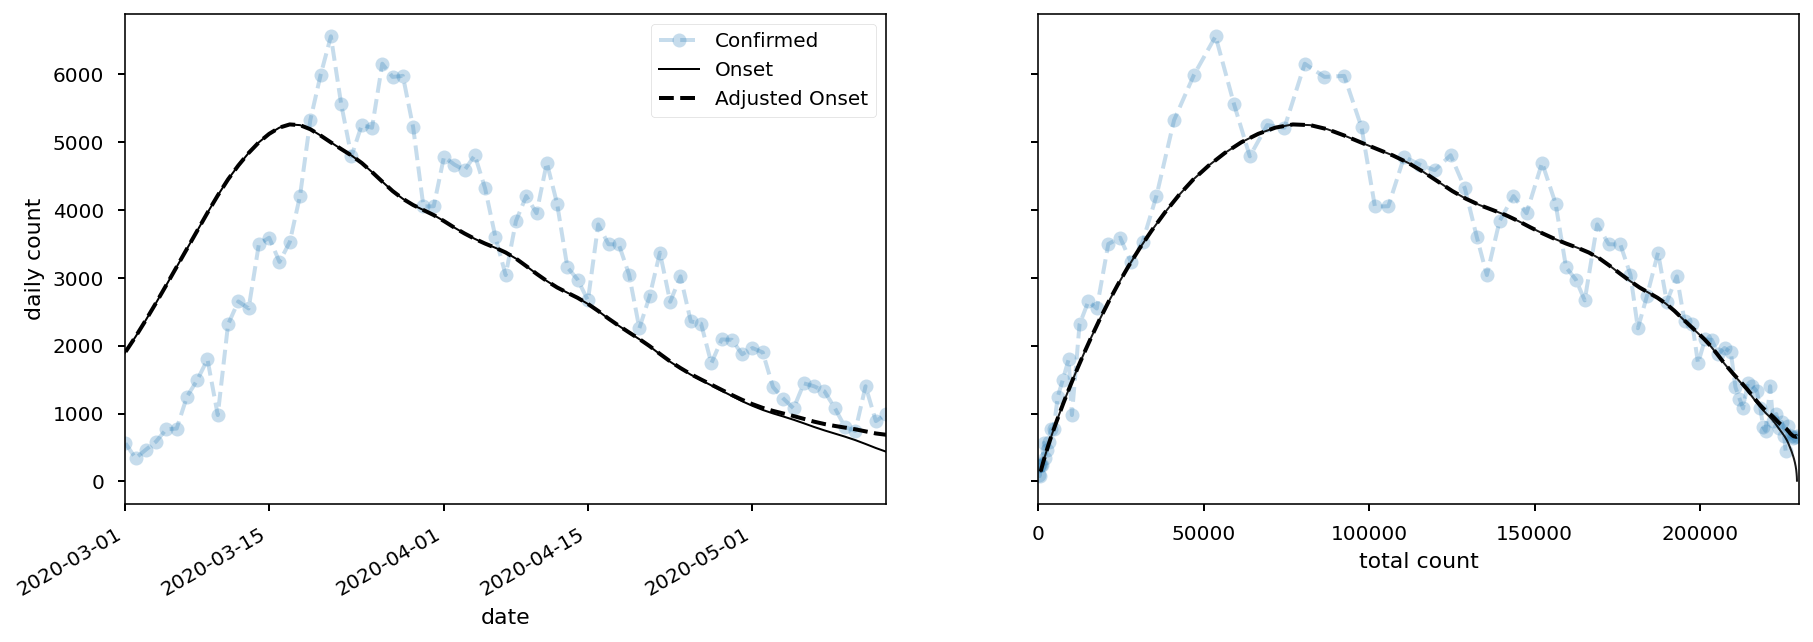

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True)

confirmed.plot(
    ax=ax[0],
    label='Confirmed',
    marker='o',
    linestyle='--',
    alpha=.25,
    lw=2)

onset.plot(
    ax=ax[0],
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax[0],
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=2)

ax[1].plot(df_national.X, df_national.I, 'o--', lw=2, alpha=.25)

n = len(df_national.X) + 10
X = onset.cumsum().iloc[-n:]
I = adjusted.iloc[-n:]
ax[1].plot(X, onset.iloc[-n:], 'k', lw=1, alpha=.9)
ax[1].plot(X, I, 'k--', lw=2, label='adjusted')
ax[1].set_xlim([0, 230000])


ax[1].set_xlabel('total count')

ax[0].set_ylabel('daily count')
ax[0].set_xlim(['2020-03-01','2020-05-14'])
ax[0].legend();

fig.savefig('smoothing_DM.pdf', bbox_inches='tight', transparent=True, dpi=300)

Finally, we will fit the adjusted time series to the controlled SIR model.

In [103]:
num_warmup = 1000
num_samples = 1000
N = df_N.Population.sum()

data = {'X': np.array(X.values),
        'I': np.array(I.values)}

obs = np.where(np.nan_to_num(data['I']) > .1, data['I'], .1)

nuts = NUTS(static, target_accept_prob=.95)
mcmc = MCMC(nuts, num_warmup, num_samples)
mcmc.run(random.PRNGKey(10101), N=N, data=data, obs=obs)
samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:10<00:00, 190.62it/s, 127 steps of size 2.04e-02. acc. prob=0.97]


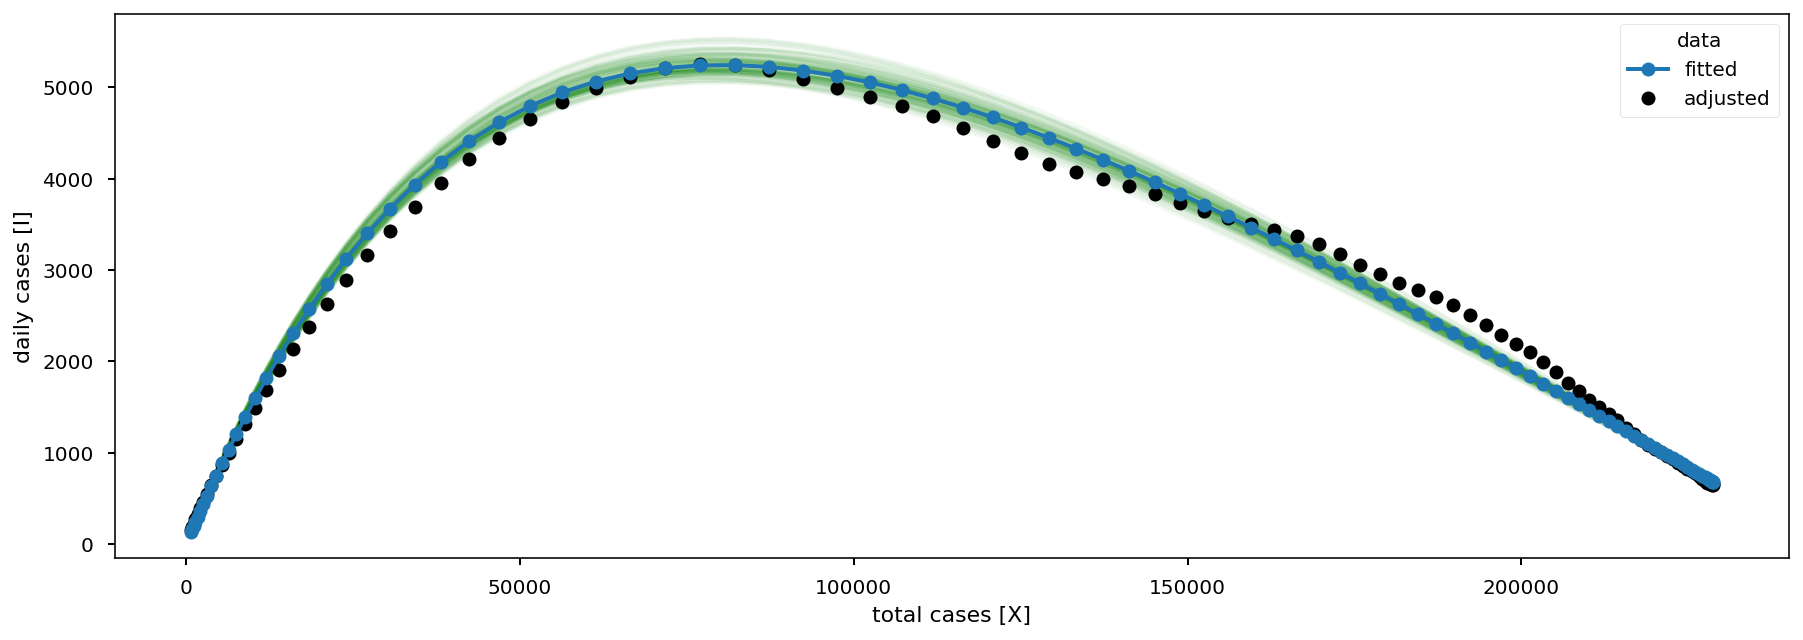

In [104]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

axes.plot(X, samples['I'].mean(0), 'o-', lw=2, zorder=10, label='fitted')
axes.plot(X, samples['I'][:100].T, 'g', alpha=.05)
axes.plot(X, I, 'ko', label='adjusted')

axes.set_ylabel('daily cases [I]');
axes.set_xlabel('total cases [X]');
axes.legend(title='data');

In [105]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I    488.29     14.26    488.61    465.21    511.70    509.25      1.00
       a_X     20.98      1.28     20.95     18.94     23.07    341.53      1.00
         f      0.34      0.02      0.34      0.30      0.38    336.76      1.00
        g0      1.21      0.01      1.21      1.20      1.22    519.93      1.00
   scale_I      0.02      0.00      0.02      0.02      0.03    543.69      1.00

Number of divergences: 0


#TODO
Given the parameter estimates from the smoothed data we can recover the time evolution of infection rate as 

$$ g(t) = \frac{g_0}{1 + \alpha_II(t) + \alpha_XX(t)}$$

as a next step we will compare the estimate of $g(t)$ obtained from the $X/I$ phase relation to a more direct model-free data driven approch proposed in https://github.com/k-sys/covid-19.